In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# 구글드라이브 연결
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 데이터파일 불러오기
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/image-10k.csv', header=None)

X1 = df.iloc[:, 1:].values     # 데이터샘플
y1 = df.iloc[:, 0].values      # 타겟레이블

x_train, x_test, y_train, y_test = train_test_split(
    X1, y1, test_size=0.5, random_state=1, stratify=y1)



print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 784) (5000,)
(5000, 784) (5000,)


Label:  Sandal


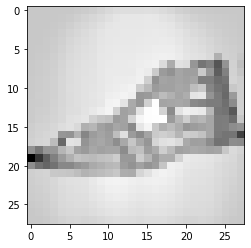

In [ ]:
images = ['T-shirt', 'Trouser', 'Sweater', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

# 테스트셋 중에 임의로 하나를 선택
r = random.randint(0, len(x_test) - 1)    
x_single_data = x_test_std[r]
y_single_data = y_test[r]

# 선택된 테스트 이미지 레이블 출력
print('Label: ', images[int(y_single_data.item())])

# 선택된 테스트 이미지 출력
plt.imshow(x_single_data.reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

여기부터 과제

In [ ]:
import torch
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms # 기존 것들을 토치로 바꾸는데 좋음
import matplotlib.pyplot as plt
import random


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# 데이터 전처리
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)


In [ ]:
# parameters
training_epochs = 50 # 학습 epochs
batch_size = 100 # 배치사이즈, 적으면  

In [ ]:
# 불러온 데이터셋을 신경망에 입력에 맞게 추가로 관리
# 불러온 데이터셋이 지금 넘파이 형태임, 텐서로 바꿔줘야함. 밑에 함수들 쓰면 편리

# dataset: 대상 데이터셋
# batch_size: 배치마다 몇개 샘플을 로드할 것인지
# shuffle: True이면 매 에폭마다 데이터를 셔플링함
# drop_last: True이면 마지막 배치가 샘플수가 모자라면 이를 버림, 배치 만들지 마라

train = torch.utils.data.TensorDataset(torch.Tensor(x_train_std), torch.Tensor(y_train).type(torch.LongTensor))
#torch.utils.data.TensorDataset = 파이토치에서 제공하는 데이터와 값을 묶어주는 함수, 여기선 X_train_std의 텐서와 
#y_train_std의 텐서를 각각  일치시켜놓은걸 train 변수안에 저장

#이제 train 함수를 배치사이즈로 쪼개야함, 밑은 그 함수
data_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [ ]:
# 각 Affine 층(입력데이터에 선형 트랜스폼 수행) 모듈을 생성

# 1번 인자: 입력 데이터 수
# 2번 인자: 출력 데이터 수
# bias: False이면 편향을 사용하지 않음

linear1 = torch.nn.Linear(784,200, bias=True) # 첫번째 선형조합, nn = neural network, 컬럼 0과 2를 가져왔으니 2개의 입력, 다가져오면 4개 입력
linear2 = torch.nn.Linear(200, 100, bias=True) # bias = 편향값 추가할거?
linear3 = torch.nn.Linear(100, 10, bias=True)


# 활성화함수 모듈을 생성
sigmoid = torch.nn.Sigmoid()
relu = torch.nn.ReLU()
lrelu = torch.nn.LeakyReLU()

#이제 위에 쪼개진 모델들 다 묶어보자 
# 만들어진 층, 활성화함수 모듈들을 순서대로 연결해서 모델 생성
# 타겟 연산 플랫폼을 설정
model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device) 

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)  # 내부에 Softmax를 포함함

In [ ]:
# 옵티마이저가 최적화할 파라미터를 넘김

# Stochastic gradient descent
# 1번 인자: 최적화할 파라미터 그룹
# lr: learning rate

optimizer = torch.optim.SGD(model.parameters(), lr=0.3) # 경사하강법 옵티마이저 사용, model.parameters()로 우리가 
# 가진 모델들의 가중치들을 다 넘겨줌


In [ ]:
for epoch in range(training_epochs):

    avg_cost = 0 # 에폭마다 0으로 초기화
    total_batch = len(data_loader) # 

    # data_loader의 데이터는 앞서 지정한 배치사이즈로 쪼개져 있음
    for X, T in data_loader: # 첫번째 배치(size=10)에서 갖고있는 X,T에 대해 밑에 함수들 돌림, 이후엔 두번째 배치에서 그 배치의 X,T를 돌림
        X = X.to(device) # 배치 데이터
        T = T.to(device) # 그 배치 데이터의 정답 값

        optimizer.zero_grad()   # 기존 계산한 경사하강법의 경사값 삭제 (초기화)
        output = model(X)       # 순방향 연산
        cost = criterion(output, T)   # 손실함수 설정
        cost.backward()         # 경사값 계산함수, backward() = 가중치 계산시간 줄여주는 기법
        optimizer.step()        # 업데이트 1회 수행

        avg_cost += cost / total_batch     # 평균 손실함수값 계산

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    # 몇번째 에폭에서 코스트가 얼만지 출력 
    
print('Learning finished')

Epoch: 0001 cost = 0.961363316
Epoch: 0002 cost = 0.571218431
Epoch: 0003 cost = 0.449207366
Epoch: 0004 cost = 0.394128799
Epoch: 0005 cost = 0.358635724
Epoch: 0006 cost = 0.314429939
Epoch: 0007 cost = 0.294027597
Epoch: 0008 cost = 0.273733020
Epoch: 0009 cost = 0.231608316
Epoch: 0010 cost = 0.246359378
Epoch: 0011 cost = 0.177280769
Epoch: 0012 cost = 0.166446060
Epoch: 0013 cost = 0.171937332
Epoch: 0014 cost = 0.150657445
Epoch: 0015 cost = 0.115160517
Epoch: 0016 cost = 0.108208016
Epoch: 0017 cost = 0.115020096
Epoch: 0018 cost = 0.083971851
Epoch: 0019 cost = 0.126107305
Epoch: 0020 cost = 0.069656789
Epoch: 0021 cost = 0.047458496
Epoch: 0022 cost = 0.059162319
Epoch: 0023 cost = 0.431160808
Epoch: 0024 cost = 0.095336288
Epoch: 0025 cost = 0.099841356
Epoch: 0026 cost = 0.054218251
Epoch: 0027 cost = 0.042408768
Epoch: 0028 cost = 0.024108032
Epoch: 0029 cost = 0.016784914
Epoch: 0030 cost = 0.011417519
Epoch: 0031 cost = 0.008685562
Epoch: 0032 cost = 0.008214224
Epoch: 0

In [ ]:
for X, T in data_loader: # 첫번째 배치(size=10)에서 갖고있는 X,T에 대해 밑에 함수들 돌림, 이후엔 두번째 배치에서 그 배치의 X,T를 돌림
        X = X.to(device) # 배치 데이터
        T = T.to(device) # 그 배치 데이터의 정답 값
        print(X,len(X[0]),len(X))
        print(T)
        break

tensor([[-0.0190, -0.0211, -0.0259,  ..., -0.1579, -0.0913, -0.0415],
        [-0.0190, -0.0211, -0.0259,  ..., -0.1579, -0.0913, -0.0415],
        [-0.0190, -0.0211, -0.0259,  ..., -0.1579, -0.0913, -0.0415],
        ...,
        [-0.0190, -0.0211, -0.0259,  ..., -0.1579, -0.0913, -0.0415],
        [-0.0190, -0.0211, -0.0259,  ..., -0.1579, -0.0913, -0.0415],
        [-0.0190, -0.0211, -0.0259,  ..., -0.1579, -0.0913, -0.0415]]) 784 100
tensor([4, 4, 6, 6, 5, 7, 6, 5, 4, 9, 4, 7, 9, 5, 4, 1, 3, 0, 6, 1, 8, 9, 7, 4,
        4, 8, 5, 9, 1, 2, 8, 1, 2, 8, 0, 4, 5, 0, 3, 1, 4, 0, 3, 5, 7, 3, 1, 7,
        1, 4, 7, 2, 9, 3, 9, 7, 4, 8, 1, 9, 1, 3, 5, 2, 8, 3, 6, 1, 1, 4, 3, 1,
        5, 5, 4, 3, 4, 9, 8, 0, 1, 2, 7, 7, 2, 4, 6, 2, 9, 1, 1, 5, 3, 2, 0, 5,
        3, 6, 3, 6])


In [ ]:
labels = ['T-shirt', 'Trouser', 'Sweater', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

In [ ]:
with torch.no_grad(): # 학습 끝났으니 가중치 업뎃 안할거임, 그걸 위한 함수 torch.no_grad()

    X_test_std = torch.tensor(x_test_std).float().to(device)
    T_test = torch.tensor(y_test).to(device)

    # 테스트셋에 대해 추론 수행
    output1 = model(X_test_std) # output은 클래스1,2,3에 대한 확률에 대한 값을 가지고 있게 됨

    # 출력값이 가장 높은 뉴런의 인덱스와 정답을 비교, 맞으면 1, 틀리면 0
    correct_prediction = torch.argmax(output1, 1) == T_test #  torch.argmax(output1, 1) = output에서 max값을 가진 데이터의 index값 출력, 정답과 맞으면 1, 틀리면 0
    #  correct_prediction = [1,0,1,1,0,~~~~] 45개의 인덱스를 가짐

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # 테스트셋 중에 임의로 하나를 선택
    r = random.randint(0, len(X_test_std) - 1)    
    X_single_data = X_test_std[r]
    T_single_data = T_test[r]

    print('Label: ', labels[T_single_data.item()])
    single_output = model(X_single_data)
    print('Prediction: ', labels[torch.argmax(single_output).item()])  

    


  

Accuracy: 0.8600000143051147
Label:  Shirt
Prediction:  Shirt


[[404   0   7  14   2   1  62   0  10   0]
 [  1 485   2  10   0   1   1   0   0   0]
 [ 10   0 401   6  45   0  33   0   5   0]
 [ 19   3   7 445  17   0   8   0   1   0]
 [  1   3  41   7 414   0  34   0   0   0]
 [  1   0   0   2   0 443   0  32   1  21]
 [ 74   2  52  14  53   2 297   0   6   0]
 [  0   0   0   0   0  16   0 456   0  28]
 [  1   0   3   2   2   4   6   1 480   1]
 [  0   0   1   0   0   4   0  27   1 467]]


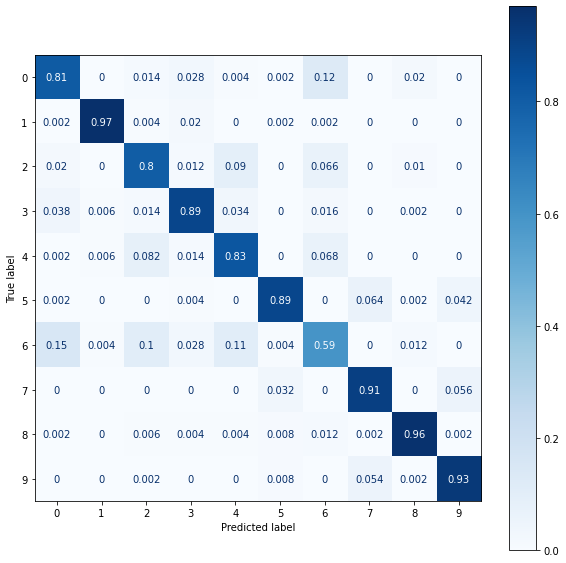

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams['figure.figsize'] = (10,10)

cm = confusion_matrix(T_test.cpu(), torch.argmax(output1, 1).cpu())
print(cm)

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 노멀라이즈하고 싶으면:
cm = cm / np.repeat(np.bincount(T_test.cpu()), 10).reshape(10,10)

cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap=plt.cm.Blues)